<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-8k/8k-item-4-02-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Financial Restatements and Non-Reliance Disclosures

We illustrate how to perform an exploratory data analysis on disclosures informing investors about non-reliance of previously issued financial statements (also known as financial restatements) of publicly traded companies on U.S. stock exchanges. These financial restatements are disclosed in Form 8-K filings with the SEC, specifically under Item 4.02, titled "Non-Reliance on Previously Issued Financial Statements or a Related Audit Report or Completed Interim Review." These disclosures are presented in text form by companies. Utilizing our Structured Data API, we extract and structure the relevant information from the text, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Item 4.02 disclosures made each year from 2004 to 2023, per quarter, month and at what time of the day (pre-market, regular market, after-market).
- Distribution of disclosures across structured data fields, such as the proportion of disclosures reporting material weaknesses in internal controls.
- Identification of the party most often responsible for discovering the issue, whether it was the company itself, its auditor, or the SEC.
- Number of times an auditor was involved in the restatement process.
- Number of reporting periods (quarters or years) affected by each restatement.
- Statistics concerning the financial statement items impacted by the restatements.


## Data Loading and Preparation

To load and prepare the data, we will use the [Form 8-K Item 4.02 Structured Data API](https://sec-api.io/docs/form-8k-data-search-api) to download all structured data related to Form 8-K filings that include Item 4.02 disclosures. The data spanning the years 2004 to 2024 is saved in a JSONL file `./form-8k-item-4-02-structured-data.jsonl`.


In [35]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "font.family": "sans-serif",
    "axes.spines.top": False, "axes.spines.right": False, "grid.color": "grey",
    "axes.grid": True, "axes.grid.axis": "y", "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [ ]:
!pip install sec-api

In [ ]:
from sec_api import Form_8K_Item_X_Api

item_X_api = Form_8K_Item_X_Api("YOUR_API_KEY")

YEARS = range(2024, 2003, -1)  # from 2024 to 2004
TARGET_FILE = "./form-8k-item-4-02-structured-data.jsonl"

if not os.path.exists(TARGET_FILE):
    for year in YEARS:
        done = False
        search_from = 0
        year_counter = 0

        while not done:
            searchRequest = {
                "query": f"item4_02:* AND filedAt:[{year}-01-01 TO {year}-12-31]",
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = item_X_api.get_data(searchRequest)

            if len(response["data"]) == 0:
                break

            search_from += 50
            year_counter += len(response["data"])

            with open(TARGET_FILE, "a") as f:
                for entry in response["data"]:
                    f.write(json.dumps(entry) + "\n")

        print(f"Finished loading {year_counter} Item 4.02 for year {year}")
else:
    print("File already exists, skipping download")

Finished loading 240 Item 4.02 for year 2024
Finished loading 262 Item 4.02 for year 2023
Finished loading 304 Item 4.02 for year 2022
Finished loading 864 Item 4.02 for year 2021
Finished loading 96 Item 4.02 for year 2020
Finished loading 98 Item 4.02 for year 2019
Finished loading 132 Item 4.02 for year 2018
Finished loading 141 Item 4.02 for year 2017
Finished loading 173 Item 4.02 for year 2016
Finished loading 216 Item 4.02 for year 2015
Finished loading 243 Item 4.02 for year 2014
Finished loading 326 Item 4.02 for year 2013
Finished loading 349 Item 4.02 for year 2012
Finished loading 402 Item 4.02 for year 2011
Finished loading 458 Item 4.02 for year 2010
Finished loading 465 Item 4.02 for year 2009
Finished loading 576 Item 4.02 for year 2008
Finished loading 786 Item 4.02 for year 2007
Finished loading 1057 Item 4.02 for year 2006
Finished loading 1013 Item 4.02 for year 2005
Finished loading 172 Item 4.02 for year 2004


### Standardization of Data Fields

The following section includes boilerplate code used to normalize various fields and enhance the dataset by deriving additional variables through field combinations. For example, the Item 4.02 dataset contains information on affected financial statement line items as disclosed in non-reliance filings. However, these line items often lack standard nomenclature, deviating from US GAAP definitions. To address this, we apply standardization techniques, such as converting "net loss" to "net income" or "cost of goods sold" to "cost of sales."  

The approach described below primarily relies on regular expressions (regex) to identify and normalize patterns, which effectively standardizes the majority of cases. However, some inconsistencies remain, leading to a small portion of false positives. For the purposes of this analysis, the error rate is considered negligible.  

A similar standardization process is applied to auditor names, ensuring consistency across entries. For instance, some companies report their auditor as "Ernst & Young," while others use the abbreviation "EY." These variations are unified under a single standardized label to improve data consistency and facilitate accurate analysis.

In [83]:
def standardize_affected_line_item(affected_line_item):
    item = affected_line_item.lower()
    item = re.sub(r"(net revenue.?|net sales)", "revenue", item, flags=re.IGNORECASE)
    item = re.sub(r"net loss", "net income", item, flags=re.IGNORECASE)
    item = re.sub(r"^net income \(loss\)$", "net income", item, flags=re.IGNORECASE)
    item = re.sub(
        r"^net income per share$", "earnings per share", item, flags=re.IGNORECASE
    )
    item = re.sub(
        r"^total current liabilities$", "current liabilities", item, flags=re.IGNORECASE
    )
    item = re.sub(
        r"^total current assets$", "current assets", item, flags=re.IGNORECASE
    )
    item = re.sub(r"^liabilities$", "total liabilities", item, flags=re.IGNORECASE)
    item = re.sub(r"^assets$", "total assets", item, flags=re.IGNORECASE)
    item = re.sub(r"^earnings$", "net income", item, flags=re.IGNORECASE)
    item = re.sub(
        r"^derivative liability$", "derivative liabilities", item, flags=re.IGNORECASE
    )
    item = re.sub(
        r"^additional paid in capital$",
        "additional paid-in capital",
        item,
        flags=re.IGNORECASE,
    )
    item = re.sub(r"^cost of goods sold$", "cost of sales", item, flags=re.IGNORECASE)
    item = re.sub(
        r"total stockholders' equity|total shareholders' equity|shareholders' equity|shareholder's equity|stockholders' equity|equity section|temporary equity|equity classification",
        "equity",
        item,
        flags=re.IGNORECASE,
    )
    item = re.sub(r"^total equity$", "equity", item, flags=re.IGNORECASE)
    # earnings per share calculation => earnings per share
    item = re.sub(
        r"earnings per share calculation|diluted earnings per share|earnings per share \(eps\)|diluted net income \(loss\) per share|loss per share",
        "earnings per share",
        item,
        flags=re.IGNORECASE,
    )
    item = re.sub(r"^net sales$", "revenue", item, flags=re.IGNORECASE)
    item = re.sub(r"^revenues$", "revenue", item, flags=re.IGNORECASE)
    return item


def standardize_affected_line_items(affected_line_items):
    if isinstance(affected_line_items, list):
        return [standardize_affected_line_item(item) for item in affected_line_items]
    return affected_line_items


def standardize_auditor(auditor: str) -> str:
    substitutions = [
        (r"\.|,", ""),
        (r"LLP", ""),
        (r" LLC", ""),
        (r" PLLC", ""),
        (r"BDO .*", "BDO"),
        (r".*PwC.*", "PricewaterhouseCoopers"),
        (r"PricewaterhouseCoopers", "PwC"),
        (r"Deloitte & Touche", "Deloitte"),
        (r"Ernst & Young", "EY"),
        (r"(.*)?Malone & Bailey(.*)?", "MaloneBailey"),
        (r"(.*)?WithumSmith(.*)?", "WithumSmith+Brown"),
    ]

    for pattern, replacement in substitutions:
        auditor = re.sub(pattern, replacement, auditor, flags=re.IGNORECASE)

    # set to empty string if the following patterns are found
    to_empty_string_patterns = [
        (r"Independent registered public accounting firm", ""),
        (r"independent registered public", ""),
        (r"Not specified", ""),
        (r"Not explicitly mentioned", ""),
        (r"Independent accountant", ""),
        (r"NaN", ""),
        (r"Unknown", ""),
    ]

    for pattern, replacement in to_empty_string_patterns:
        # check if pattern is found in auditor. if yes, return empty string
        if re.search(pattern, auditor, flags=re.IGNORECASE):
            return "Unknown"

    if auditor == "":
        return "Unknown"

    return auditor.strip()


def standardize_auditors(auditors):
    if isinstance(auditors, list):
        return [standardize_auditor(auditor) for auditor in auditors]
    return auditors

In [84]:
structured_data = pd.read_json(TARGET_FILE, lines=True)

# add date-related columns
structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["filedAt"].dt.quarter
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)
# convert long-form of each item into item id only, e.g. "Item 4.02: ..." => "4.02"
structured_data["items"] = structured_data["items"].apply(
    lambda items: [re.search(r"\d+\.\d+", x).group(0) if x else None for x in items]
)
# explode column "item4_02" into multiple columns
# where each column is a key-value pair of the JSON object
# and drop all structured data columns for items, eg "item5_02"
item_cols = list(
    structured_data.columns[
        structured_data.columns.str.contains(r"item\d+_", case=False)
    ]
)
structured_data = pd.concat(
    [
        structured_data.drop(item_cols, axis=1),
        structured_data["item4_02"].apply(pd.Series),
    ],
    axis=1,
)
# drop "id" column
structured_data.drop(["id"], axis=1, inplace=True)
# standardize affected line itmes
structured_data["affectedLineItems"] = structured_data["affectedLineItems"].apply(
    standardize_affected_line_items
)
# standardize auditor names
structured_data["auditors"] = structured_data["auditors"].apply(standardize_auditors)
# add "hasBig4Auditor" (bool). True if auditor is one of the Big 4 (Deloitte, EY, KPMG, PwC)
structured_data["hasBig4Auditor"] = structured_data["auditors"].apply(
    lambda x: any(auditor in ["Deloitte", "EY", "KPMG", "PwC"] for auditor in x)
)
# add column: "numberPeriodsAffected" = number of periods affected
structured_data["numberPeriodsAffected"] = structured_data[
    "affectedReportingPeriods"
].apply(lambda x: len(x) if isinstance(x, list) else 0)
# add column: "numberQuartersAffected" = number of "Q\d" occurrences in "affectedReportingPeriods"
structured_data["numberQuartersAffected"] = structured_data[
    "affectedReportingPeriods"
].apply(lambda x: len([period for period in x if re.search(r"Q\d", period)]))
# add column: "numberYearsAffected" = number of "FY" occurrences in "affectedReportingPeriods"
structured_data["numberYearsAffected"] = structured_data[
    "affectedReportingPeriods"
].apply(lambda x: len([period for period in x if re.search(r"FY", period)]))
# add "reportedWithEarnings" (bool). True if item 2.02 or 9.01 is present
structured_data["reportedWithEarnings"] = structured_data["items"].apply(
    lambda x: "2.02" in x or "9.01" in x
)
# add "reportedWithOtherItems" (bool). True if more than one item is present
structured_data["reportedWithOtherItems"] = structured_data["items"].apply(
    lambda x: len(x) > 1
)
# add column "issueIdentifiedByAuditor" (bool).
structured_data["identifiedByAuditor"] = structured_data["identifiedBy"].apply(
    lambda x: "Auditor" in x if isinstance(x, list) else False
)
# add column "identifiedByCompany"
structured_data["identifiedByCompany"] = structured_data["identifiedBy"].apply(
    lambda x: "Company" in x if isinstance(x, list) else False
)
# add column "identifiedBySec"
structured_data["identifiedBySec"] = structured_data["identifiedBy"].apply(
    lambda x: "SEC" in x if isinstance(x, list) else False
)
# check if revenue or net income adjustment contains "million" or "billion"
structured_data["revenueAdjustmentContainsWordMillion"] = structured_data[
    "revenueAdjustment"
].apply(
    # lambda x: "million" in x if isinstance(x, str) else False
    # use case insensitive regex to match "million" or "billion" and return boolean
    # True if match, False otherwise
    lambda x: (
        bool(re.search(r"million|billion", x, re.IGNORECASE))
        if isinstance(x, str)
        else False
    )
)
structured_data["netIncomeAdjustmentContainsWordMillion"] = structured_data[
    "netIncomeAdjustment"
].apply(
    lambda x: (
        bool(re.search(r"million|billion", x, re.IGNORECASE))
        if isinstance(x, str)
        else False
    )
)

In [85]:
print(
    f"Loaded {len(structured_data):,} records from Item 4.02 disclosures between 2004 to 2024."
)
structured_data.head()

Loaded 8,373 records from Item 4.02 disclosures between 2004 to 2024.


,accessionNo,formType,filedAt,periodOfReport,cik,ticker,companyName,items,year,month,...,numberPeriodsAffected,numberQuartersAffected,numberYearsAffected,reportedWithEarnings,reportedWithOtherItems,identifiedByAuditor,identifiedByCompany,identifiedBySec,revenueAdjustmentContainsWordMillion,netIncomeAdjustmentContainsWordMillion
0,0001477932-24-008354,8-K,2024-12-27 17:29:12-05:00,2024-12-24,1437750,TRXA,T-REX Acquisition Corp.,"[4.02, 5.02]",2024,12,...,1,0,1,False,True,True,True,False,False,False
1,0001437749-24-038225,8-K,2024-12-23 08:00:28-05:00,2024-12-20,1000230,OCC,OPTICAL CABLE CORP,[4.02],2024,12,...,7,6,1,False,False,False,True,False,False,False
2,0001683168-24-008906,8-K,2024-12-23 07:52:53-05:00,2024-12-19,725394,DFCO,DALRADA FINANCIAL CORP,[4.02],2024,12,...,1,1,0,False,False,False,True,False,False,False
3,0001437749-24-038156,8-K,2024-12-20 17:15:00-05:00,2024-12-19,914122,PPIH,"Perma-Pipe International Holdings, Inc.",[4.02],2024,12,...,1,1,0,False,False,False,True,False,False,False
4,0001140361-24-049546,8-K,2024-12-13 17:16:31-05:00,2024-12-10,1856028,SDIG,"Stronghold Digital Mining, Inc.","[4.02, 9.01]",2024,12,...,3,3,0,True,True,False,True,True,False,False


## Vizualization of Non-Reliance Disclosures over Time


In [86]:
item_4_02_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"Item 4.02 counts from 2004 to 2024.")
item_4_02_counts.T

Item 4.02 counts from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,171,962,1004,780,572,465,455,402,346,326,...,213,173,141,132,98,96,864,304,262,240


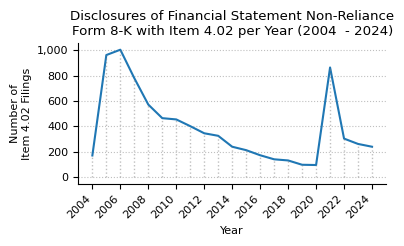

In [87]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nItem 4.02 Filings")
    ax.set_xticks(np.arange(2004, 2025, 2))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(2003, 2025)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in YEARS:
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    item_4_02_counts,
    title="Disclosures of Financial Statement Non-Reliance\nForm 8-K with Item 4.02 per Year (2004  - 2024)",
)

In [88]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "qtr"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.02 counts by quarter from 2004 to 2024.")
counts_qtr_yr_piv.T

Item 4.02 counts by quarter from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,,,,,,,,,,,,,
1,0,301,281,239,187,118,132,120,99,106,...,57,59,34,41,27,28,29,136,80,61
2,0,221,222,201,132,105,131,115,95,97,...,49,42,41,34,28,24,370,56,62,70
3,33,190,239,168,130,124,94,76,79,54,...,54,31,28,20,20,22,39,59,59,52
4,138,250,262,172,123,118,98,91,73,69,...,53,41,38,37,23,22,426,53,61,57


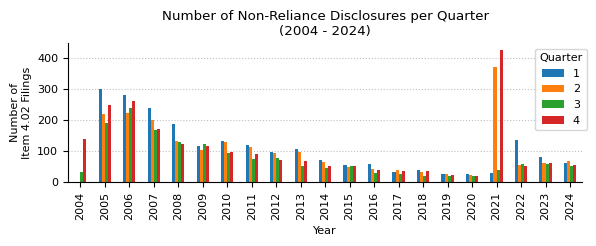

In [89]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.02, 1))
ax.set_title("Number of Non-Reliance Disclosures per Quarter\n(2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 4.02 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [90]:
counts_month_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.02 counts by month from 2004 to 2024.")
counts_month_yr_piv

Item 4.02 counts by month from 2004 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2004,0,0,0,0,0,0,0,7,26,29,63,46
2005,37,89,175,85,91,45,46,91,53,63,123,64
2006,45,84,152,81,78,63,60,115,64,76,109,77
2007,60,67,112,85,62,54,41,91,36,53,76,43
2008,40,74,73,63,45,24,32,62,36,31,60,32
2009,33,40,45,50,33,22,31,46,47,36,58,24
2010,37,41,54,49,48,34,23,47,24,34,32,32
2011,24,26,70,49,39,27,28,31,17,30,45,16
2012,26,28,45,39,31,25,26,35,18,26,38,9


In [91]:
print(f"Descriptive statistics for Item 4.02 counts by month from 2005 to 2024.")
month_stats = (
    counts_month_yr_piv.loc[2005:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Item 4.02 counts by month from 2005 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,20,20,20,20,20,20,20,20,20,20,20,20
mean,23,35,53,40,46,22,21,37,21,25,53,28
std,16,25,45,24,56,18,15,30,17,19,60,35
min,2,7,13,9,10,3,3,8,3,5,10,4
2.5%,3,8,13,10,10,3,4,9,3,5,10,4
50%,18,26,45,36,31,20,16,28,15,18,31,14
97.5%,53,87,164,85,182,59,53,104,59,70,201,115
max,60,89,175,85,264,63,60,115,64,76,271,149


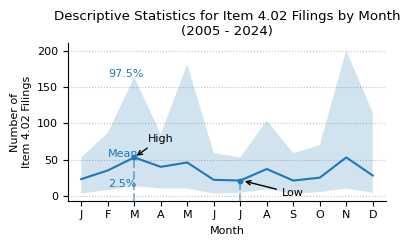

In [92]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,  # {"mean": {"x": 2, "y": 150}, "upper": {"x": 2, "y": 150}, "lower": {"x": 2, "y": 150}},
    pos_high_low=None,  # {"high": {"x": 2, "y": 150}, "low": {"x": 2, "y": 150}},
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title="Descriptive Statistics for Item 4.02 Filings by Month\n(2005 - 2024)",
    x_label="Month",
    y_label="Number of\nItem 4.02 Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
)

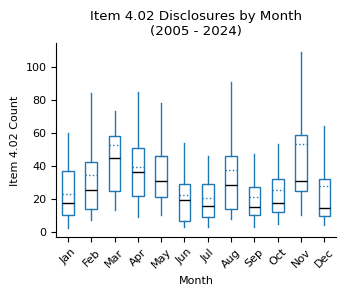

In [93]:
fig, ax = plt.subplots(figsize=(3.5, 3))

counts_month_yr_piv.loc[2005:].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title("Item 4.02 Disclosures by Month\n(2005 - 2024)")
ax.set_xlabel("Month")
ax.set_ylabel("Item 4.02 Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("regularMarket", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Item 4.02 counts by pre-market, regular market hours,\nand after-market publication time (2004 - 2025)."
)
counts_filedAtClass

Item 4.02 counts by pre-market, regular market hours,
and after-market publication time (2004 - 2025).


,Count,Pct
Publication Time,,
other,304,4%
Pre-Market (4:00 - 9:30 AM),943,11%
Market Hours (9:30 AM - 4:00 PM),"2,049",25%
After Market (4:00 - 8:00 PM),"4,950",60%


In [95]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Item 4.02 disclosures by day of the week (2004 - 2024).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Item 4.02 disclosures by day of the week (2004 - 2024).


,Count,Pct
Day of the Week,,
Monday,"1,639",20%
Tuesday,"1,705",21%
Wednesday,"1,532",19%
Thursday,"1,560",19%
Friday,"1,810",22%


## Distribution of Disclosures by Their Characteristics


In [96]:

bool_variables_to_analyze = [
    "impactIsMaterial",
    "restatementIsNecessary",
    "impactYetToBeDetermined",
    "materialWeaknessIdentified",
    "reportedWithOtherItems",
    "reportedWithEarnings",
    "netIncomeDecreased",
    "netIncomeIncreased",
    "netIncomeAdjustmentContainsWordMillion",
    "revenueDecreased",
    "revenueIncreased",
    "revenueAdjustmentContainsWordMillion",
    "identifiedByAuditor",
    "identifiedByCompany",
    "identifiedBySec",
]

var_to_label = {
    "impactIsMaterial": "Impact is Material",
    "restatementIsNecessary": "Restatement is Necessary",
    "impactYetToBeDetermined": "Impact Yet to be Determined",
    "materialWeaknessIdentified": "Material Weakness Identified",
    "reportedWithOtherItems": "Reported with Other Items",
    "reportedWithEarnings": "Reported with Earnings Announcement",
    "netIncomeDecreased": "Net Income Decreased",
    "netIncomeIncreased": "Net Income Increased",
    "netIncomeAdjustmentContainsWordMillion": "Net Inc. Adj. Contains 'Million'",
    "revenueDecreased": "Revenue Decreased",
    "revenueIncreased": "Revenue Increased",
    "revenueAdjustmentContainsWordMillion": "Revenue Adj. Contains 'Million'",
    "identifiedByAuditor": "Identified by Auditor",
    "identifiedByCompany": "Identified by Company",
    "identifiedBySec": "Identified by SEC",
}

bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        structured_data[variable]
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={variable: "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)


bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(index=var_to_label, columns={"count": "Samples", "pct": "Pct."}, inplace=True)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(lambda x: f"{x:,.0f}")

print(f"Number of non-reliance filings by \ntheir disclosed characteristics (2004 - 2024):")
bool_variables_stats

Number of non-reliance filings by 
their disclosed characteristics (2004 - 2024):


Samples  Pct.
Variable                            Value              
Impact is Material                  True    6,224  74.3
                                    False   2,149  25.7
Restatement is Necessary            True    8,155  97.4
                                    False     218   2.6
Impact Yet to be Determined         True    2,052  24.5
                                    False   6,321  75.5
Material Weakness Identified        True    2,241  26.8
                                    False   6,132  73.2
Reported with Other Items           True    3,676  43.9
                                    False   4,697  56.1
Reported with Earnings Announcement True    3,248  38.8
                                    False   5,125  61.2
Net Income Decreased                True    2,084  24.9
                                    False   6,289  75.1
Net Income Increased                True      758   9.1
                                    False   7,615  90.9
Net Inc. Adj. Contains 'Million'    True      449   5.4
                                    False   7,924  94.6
Revenue Decreased                   True      633   7.6
                                    False   7,740  92.4
Revenue Increased                   True      204   2.4
                                    False   8,169  97.6
Revenue Adj. Contains 'Million'     True      196   2.3
                                    False   8,177  97.7
Identified by Auditor               True    2,173  26.0
                                    False   6,200  74.0
Identified by Company               True    6,996  83.6
                                    False   1,377  16.4
Identified by SEC                   True    1,279  15.3
                                    False   7,094  84.7

## Parties Responsible for Discovering Issues


In [97]:
identifiedBy = (
    structured_data["identifiedBy"].explode().value_counts().to_frame().head(3)
)
identifiedBy.index.name = "Identified By"
identifiedBy.columns = ["Count"]
identifiedBy["Pct."] = identifiedBy["Count"] / identifiedBy["Count"].sum() * 100
identifiedBy["Pct."] = identifiedBy["Pct."].round(1)
identifiedBy["Count"] = identifiedBy["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Top 3 entities identifying issues in\npreviously reported financial statements (2004 - 2024):"
)
identifiedBy

Top 3 entities identifying issues in
previously reported financial statements (2004 - 2024):


,Count,Pct.
Identified By,,
Company,"6,996",67.0
Auditor,"2,173",20.8
SEC,"1,279",12.2


## Most Involved Auditors in Restatements


In [98]:
all_auditors = structured_data["auditors"].explode()
all_auditors = all_auditors[all_auditors.str.len() > 0].reset_index(drop=True)
auditors = all_auditors.value_counts().to_frame().reset_index()
auditors["pct"] = auditors["count"] / auditors["count"].sum() * 100
auditors["pct"] = auditors["pct"].round(2)

print("Top 10 auditors involved in \nnon-reliance disclosures from 2004 to 2024:")
auditors.head(10)

Top 10 auditors involved in 
non-reliance disclosures from 2004 to 2024:


,auditors,count,pct
0,PwC,639,9.50
1,EY,598,8.89
2,Marcum,477,7.09
3,Deloitte,436,6.48
4,KPMG,430,6.39
5,WithumSmith+Brown,335,4.98
6,BDO,327,4.86
7,Unknown,324,4.82
8,Grant Thornton,179,2.66
9,MaloneBailey,100,1.49


In [99]:
auditors_year = structured_data[["auditors", "year", "accessionNo"]].explode("auditors")

auditors_year_pivot = pd.pivot_table(
    auditors_year,
    index="auditors",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

auditors_year_pivot["total"] = auditors_year_pivot.sum(axis=1)
auditors_year_pivot = auditors_year_pivot.sort_values(by="total", ascending=False)

top_10_auditors = auditors_year_pivot.head(10)

others = auditors_year_pivot[~auditors_year_pivot.index.isin(top_10_auditors.index)]
others = others.sum().to_frame().T
others.index = ["Others"]

top_10_auditors = pd.concat([top_10_auditors, others], axis=0)

top_10_auditors

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
PwC,42,159,149,48,28,21,20,14,18,17,...,16,5,11,6,6,9,10,13,13,639
EY,20,87,83,85,31,31,12,18,25,31,...,14,8,7,3,7,24,16,26,28,598
Marcum,0,0,0,0,0,3,5,5,1,4,...,3,2,1,5,5,340,45,36,18,477
Deloitte,11,103,104,54,38,20,13,10,8,11,...,16,5,3,0,1,6,2,9,6,436
KPMG,24,116,78,54,30,13,11,10,7,15,...,4,3,0,4,5,29,10,4,5,430
WithumSmith+Brown,0,0,0,0,0,0,1,0,0,2,...,4,0,0,0,0,237,58,17,13,335
BDO,8,44,23,26,24,2,12,6,11,7,...,15,15,17,11,13,18,33,17,10,327
Unknown,7,63,40,35,25,14,20,10,12,19,...,1,5,1,4,2,36,6,4,1,324
Grant Thornton,4,34,20,23,10,7,14,3,11,3,...,3,0,3,1,3,10,6,3,16,179
MaloneBailey,0,8,9,19,3,4,14,15,2,1,...,1,2,6,1,0,2,2,5,1,100


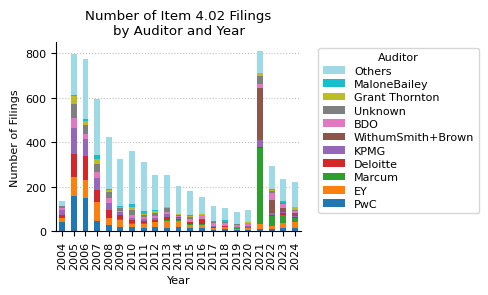

In [100]:
fig, ax = plt.subplots(figsize=(5, 3))

top_10_auditors.drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.02 Filings\nby Auditor and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items
ax.legend(
    reversed(handles),
    reversed(labels),
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Affected Periods by Restatements


In [101]:
print(
    f"Descriptive statistics for number of years and quarters \naffected by Item 4.02 filings (2004 - 2024):"
)
quarters_stats = (
    structured_data[["numberQuartersAffected", "numberYearsAffected"]]
    .describe()
    .round(0)
    .astype(int)
)
quarters_stats.T

Descriptive statistics for number of years and quarters 
affected by Item 4.02 filings (2004 - 2024):


,count,mean,std,min,25%,50%,75%,max
numberQuartersAffected,8373,2,3,0,1,2,3,56
numberYearsAffected,8373,1,1,0,0,1,2,20


## Affected Financial Statement Items


In [102]:
affectedLineItems_stats = (
    structured_data["affectedLineItems"]
    .explode()
    .value_counts()
    .to_frame()
    .reset_index()
    .head(10)
)
print(
    f"Top 10 line items affected by non-reliance disclosures\nacross all years (2004 - 2024):"
)
affectedLineItems_stats

Top 10 line items affected by non-reliance disclosures
across all years (2004 - 2024):


,affectedLineItems,count
0,net income,2346
1,equity,1075
2,revenue,966
3,total liabilities,679
4,additional paid-in capital,672
5,earnings per share,564
6,accumulated deficit,543
7,total assets,450
8,retained earnings,404
9,warrants,334


In [103]:
line_items_year_pivot = pd.pivot_table(
    structured_data.explode("affectedLineItems"),
    index="affectedLineItems",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
    margins=True,
)
line_items_year_pivot = line_items_year_pivot.sort_values(by="All", ascending=False)
print(f"Top 20 line items affected by Item 4.02 filings per year (2004 - 2023):")
line_items_year_pivot.head(20)

Top 20 line items affected by Item 4.02 filings per year (2004 - 2023):


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,All
affectedLineItems,,,,,,,,,,,,,,,,,,,,,
All,508,3089,3468,2424,2114,1684,1757,1422,1142,1171,...,610,394,402,367,346,2256,903,850,784,27320
net income,55,348,301,226,208,127,159,118,95,85,...,42,27,30,34,31,152,59,65,41,2346
equity,11,65,109,49,45,43,58,50,27,42,...,14,7,13,15,7,403,47,26,13,1075
revenue,31,150,104,81,70,48,46,50,37,48,...,29,26,21,22,22,23,28,36,30,966
total liabilities,11,37,56,35,26,37,41,43,23,26,...,12,8,7,9,10,194,24,16,16,679
additional paid-in capital,3,39,65,73,52,48,49,36,18,24,...,11,8,6,9,8,108,52,10,21,672
earnings per share,8,56,69,48,53,18,39,33,26,13,...,5,5,7,6,5,82,52,11,11,564
accumulated deficit,8,24,39,51,38,25,30,28,20,24,...,8,5,7,5,11,103,50,13,23,543
total assets,10,38,38,34,40,43,24,35,20,28,...,11,14,9,7,9,6,11,11,16,450
